In [1]:
%%capture
!pip install neurokit2 tqdm

In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import neurokit2 as nk
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks
import torch.nn.functional as F

# Step 1: Generate Dataset

def generate_ecg_signal(duration, sampling_rate=1000, heart_rate=70, noise_level=0.05):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate)
    noise = np.random.normal(0, noise_level, size=ecg.shape)
    return ecg + noise

def create_dataset(num_samples=1000, duration=2):
    dataset = []
    sampling_rate = 1000

    for _ in range(num_samples):
        maternal_ecg = generate_ecg_signal(duration, sampling_rate, heart_rate=70, noise_level=0.05)
        fetal_ecg = 0.1 * generate_ecg_signal(duration, sampling_rate, heart_rate=120, noise_level=0.1)

        combined_ecg = maternal_ecg + fetal_ecg
        dataset.append((combined_ecg, maternal_ecg, fetal_ecg))

    return dataset

class ECGDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        combined, maternal, fetal = self.dataset[idx]
        return torch.tensor(combined, dtype=torch.float32), torch.tensor(maternal, dtype=torch.float32), torch.tensor(fetal, dtype=torch.float32)

# Step 2: Define the CNN Architecture

class ECGSeparator(nn.Module):
    def __init__(self):
        super(ECGSeparator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 2, kernel_size=3, padding=1) # Output two channels: maternal and fetal
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Step 3: Define Training Pipeline
def kurtosis_loss(k_f, k_m):
    maximize_kf_km = - (k_f + k_m)
    penalty =  100 * torch.relu(k_f - k_m)
    loss = maximize_kf_km + penalty
    return torch.mean(loss)

def peak_count_loss(maternal_pred, fetal_pred, prominence=0.5, distance=400):
    batch_size = maternal_pred.size(0)
    total_penalty = 0.0
    for i in range(batch_size):
        maternal_peaks, _ = find_peaks(maternal_pred[i].cpu().detach().numpy(), prominence=0.5, distance=400, height=1)
        fetal_peaks, _ = find_peaks(fetal_pred[i].cpu().detach().numpy(), prominence=0.5, distance=400, height=0.1)
        pred_peaks = torch.tensor(maternal_peaks)
        target_peaks = torch.tensor(fetal_peaks)
            
        # Penalize if the peaks are very close to each other
        for pred_peak in pred_peaks:
            for target_peak in target_peaks:
                if abs(pred_peak - target_peak) < 50:
                    total_penalty += 1

    # Average penalty across the batch
    average_penalty = total_penalty / batch_size
    return average_penalty

def train_model(model, dataloader, num_epochs=50, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for combined, _, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            combined = combined.unsqueeze(1)  # Add channel dimension
            outputs = model(combined)

            maternal_pred = outputs[:, 0, :]
            fetal_pred = outputs[:, 1, :]

            # Compute kurtosis loss
            k_m = torch.tensor(np.abs(np.nan_to_num([kurtosis(maternal_pred[i].cpu().detach().numpy(), nan_policy='omit') for i in range(maternal_pred.size(0))])), dtype=torch.float32, requires_grad=True)
            k_f = torch.tensor(np.abs(np.nan_to_num([kurtosis(fetal_pred[i].cpu().detach().numpy(), nan_policy='omit') for i in range(fetal_pred.size(0))])), dtype=torch.float32, requires_grad=True)
            #loss_kurtosis = -torch.mean(torch.tensor(np.abs(maternal_kurtosis), dtype=torch.float32, requires_grad=True)) + torch.mean(torch.tensor(np.abs(fetal_kurtosis), dtype=torch.float32, requires_grad=True))

            # Regularization term: MSE between combined input and sum of predictions
            reconstruction = maternal_pred + fetal_pred
            loss_reconstruction = mse_loss(reconstruction, combined.squeeze(1))

            fetal_infer = combined - maternal_pred
            loss_infer = mse_loss(fetal_infer, fetal_pred)

            peak_loss = peak_count_loss(maternal_pred, fetal_pred)

            sim_loss = torch.abs(F.cosine_similarity(fetal_pred, maternal_pred, dim=1)).mean()
            sim_mse_loss = -torch.sigmoid(mse_loss(maternal_pred, fetal_pred))
            loss = 0.001* kurtosis_loss(k_f, k_m)  + loss_reconstruction + loss_infer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

#

In [3]:
# Create the dataset
dataset = create_dataset(num_samples=2000, duration=2)
ecg_dataset = ECGDataset(dataset)
dataloader = DataLoader(ecg_dataset, batch_size=32, shuffle=True)

In [38]:

model = ECGSeparator()
train_model(model, dataloader, num_epochs=20, learning_rate=0.0001)


Epoch 1/20:   0%|          | 0/63 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 2000])) that is different to the input size (torch.Size([32, 32, 2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20:  98%|█████████▊| 62/63 [00:04<00:00, 13.88it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 2000])) that is different to the input size (torch.Size([16, 16, 2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20: 100%|██████████| 63/63 [00:04<00:00, 13.09it/s]


Epoch 1/20, Loss: 0.34400489015711677


Epoch 2/20: 100%|██████████| 63/63 [00:04<00:00, 14.56it/s]


Epoch 2/20, Loss: 0.04718886803658236


Epoch 3/20: 100%|██████████| 63/63 [00:04<00:00, 14.25it/s]


Epoch 3/20, Loss: 0.004148277982566801


Epoch 4/20: 100%|██████████| 63/63 [00:04<00:00, 14.34it/s]


Epoch 4/20, Loss: -0.0014773604962679129


Epoch 5/20: 100%|██████████| 63/63 [00:04<00:00, 14.63it/s]


Epoch 5/20, Loss: -0.002315729908231232


Epoch 6/20: 100%|██████████| 63/63 [00:04<00:00, 14.41it/s]


Epoch 6/20, Loss: -0.0025889453892078665


Epoch 7/20: 100%|██████████| 63/63 [00:04<00:00, 14.46it/s]


Epoch 7/20, Loss: -0.002908222661871049


Epoch 8/20: 100%|██████████| 63/63 [00:04<00:00, 14.49it/s]


Epoch 8/20, Loss: -0.0033127745199534628


Epoch 9/20: 100%|██████████| 63/63 [00:04<00:00, 14.31it/s]


Epoch 9/20, Loss: -0.0035673542657778377


Epoch 10/20: 100%|██████████| 63/63 [00:04<00:00, 14.28it/s]


Epoch 10/20, Loss: -0.00370252871560672


Epoch 11/20: 100%|██████████| 63/63 [00:04<00:00, 14.28it/s]


Epoch 11/20, Loss: -0.0037557526846371944


Epoch 12/20: 100%|██████████| 63/63 [00:04<00:00, 14.62it/s]


Epoch 12/20, Loss: -0.003794653241389564


Epoch 13/20: 100%|██████████| 63/63 [00:04<00:00, 14.55it/s]


Epoch 13/20, Loss: -0.0038273667968395683


Epoch 14/20: 100%|██████████| 63/63 [00:04<00:00, 14.62it/s]


Epoch 14/20, Loss: -0.0038533685433249625


Epoch 15/20: 100%|██████████| 63/63 [00:04<00:00, 14.34it/s]


Epoch 15/20, Loss: -0.0038728960494082126


Epoch 16/20: 100%|██████████| 63/63 [00:04<00:00, 14.36it/s]


Epoch 16/20, Loss: -0.0038893213089082447


Epoch 17/20: 100%|██████████| 63/63 [00:04<00:00, 14.36it/s]


Epoch 17/20, Loss: -0.0038987687042367366


Epoch 18/20: 100%|██████████| 63/63 [00:04<00:00, 14.31it/s]


Epoch 18/20, Loss: -0.003908991835834015


Epoch 19/20: 100%|██████████| 63/63 [00:04<00:00, 14.05it/s]


Epoch 19/20, Loss: -0.00391746977240675


Epoch 20/20: 100%|██████████| 63/63 [00:04<00:00, 14.69it/s]

Epoch 20/20, Loss: -0.003925147510710217


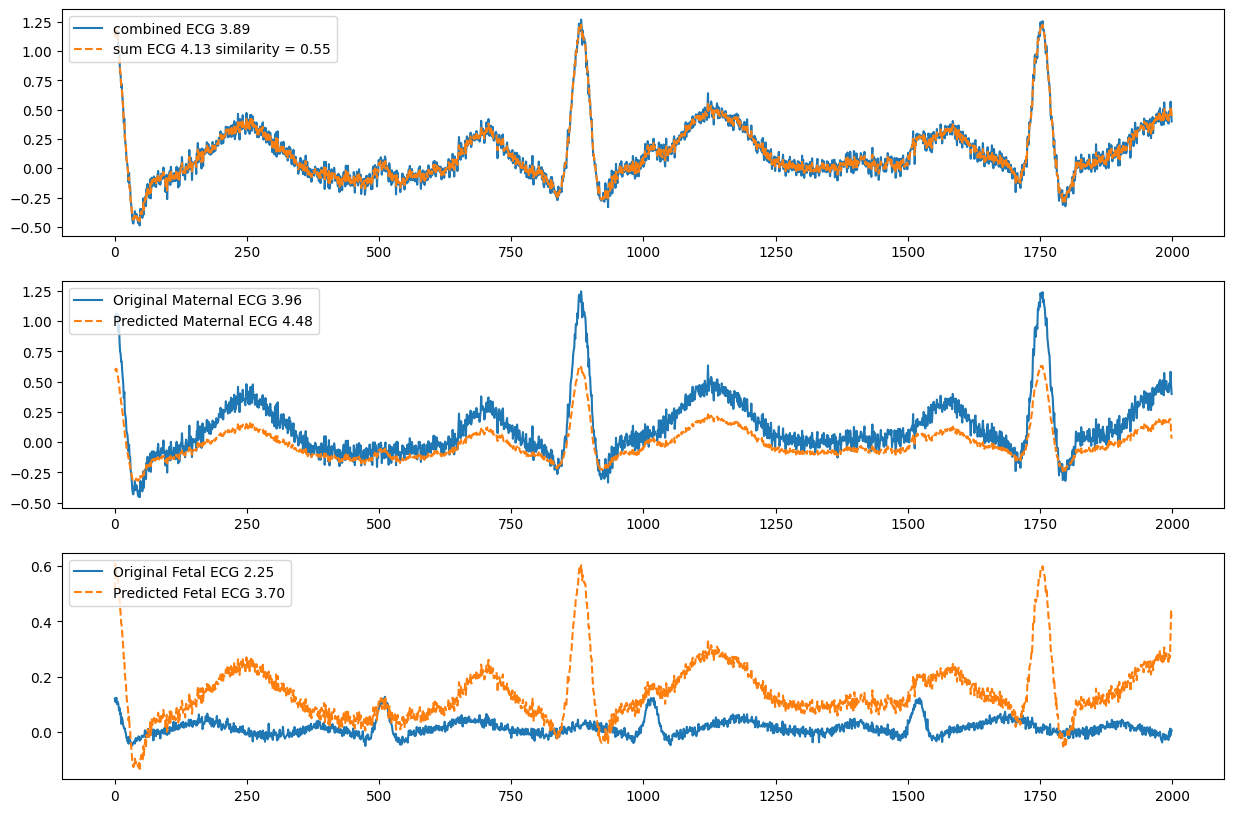

In [39]:
# Load one sample from the dataset
combined, maternal, fetal = ecg_dataset[0]
combined = combined.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Predict separated signals
model.eval()
with torch.no_grad():
    output = model(combined)
    maternal_pred = output[0, 0, :].numpy()
    fetal_pred = output[0, 1, :].numpy()

# Plot original and separated signals
plt.figure(figsize=(15, 10))
similarity =  F.cosine_similarity(torch.tensor(maternal_pred).unsqueeze(1), torch.tensor(fetal_pred).unsqueeze(1), dim=0)[0].numpy()
plt.subplot(3, 1, 1)
plt.plot(combined[0, 0, :].numpy(), label=f'combined ECG {kurtosis(combined[0, 0, :].numpy()):.2f}')
plt.plot(fetal_pred + maternal_pred, label=f'sum ECG {kurtosis(fetal_pred + maternal_pred):.2f} similarity = {similarity:.2f}', linestyle='dashed')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(maternal.numpy(), label=f'Original Maternal ECG {kurtosis(maternal.numpy()):.2f}')
plt.plot(maternal_pred, label=f'Predicted Maternal ECG {kurtosis(maternal_pred):.2f}', linestyle='dashed')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(fetal.numpy(), label=f'Original Fetal ECG {kurtosis(fetal.numpy()):.2f}')
plt.plot(fetal_pred, label=f'Predicted Fetal ECG {kurtosis(fetal_pred):.2f}', linestyle='dashed')
plt.legend()

plt.show()

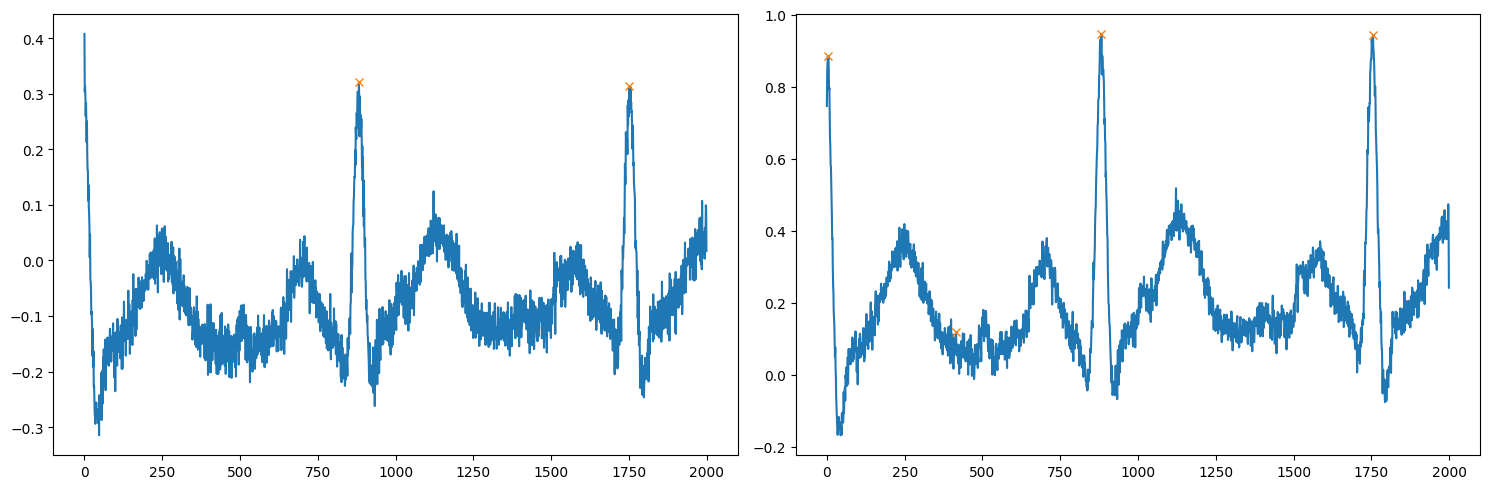

In [21]:
peaks_f, _ = find_peaks(maternal_pred, prominence=0.5, distance=400)
peaks_ff, _ = find_peaks(fetal_pred, prominence=0.1, distance=400)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(maternal_pred)
plt.plot(peaks_f, maternal_pred[peaks_f], "x")

plt.subplot(1,2,2)
plt.plot(fetal_pred)
plt.plot(peaks_ff, fetal_pred[peaks_ff], "x")
plt.tight_layout()